In [1]:
from astropy.io import fits

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable, viridis

import healpy as hp
import pymaster as nmt

from DES_CDM import *

In [2]:
c = cosmology()

In [31]:
data = np.load("halo_model_power_spectra_substructure04.npz")

k = data["k"]
z = data["z"]

In [32]:
ps_halomod = power_spectrum(zmin=0.1, zmax=z.max(),kmin=k.min()+1e-8,kmax=k.max()-1e-8,Pmm_file = 'standard_halo_model_power_spectra04.npz',Pmm_field= "P_hh_total")

kmin = 1.000e-03, kmax = 1.000e+05, chimin = 4.341e+02, chimax = 8.424e+03, zmin = 0.100, zmax = 6.000
Loaded Pmm from file: standard_halo_model_power_spectra04.npz, field: P_hh_total


In [33]:
ps_sub = power_spectrum(zmin=0.1, zmax=z.max(),kmin=k.min()+1e-8,kmax=k.max()-1e-8,Pmm_file = "halo_model_power_spectra_substructure04.npz",Pmm_field= "P_hh_total")

kmin = 1.000e-03, kmax = 1.000e+05, chimin = 4.341e+02, chimax = 8.424e+03, zmin = 0.100, zmax = 6.000
Loaded Pmm from file: halo_model_power_spectra_substructure04.npz, field: P_hh_total


In [6]:
ps_lin = power_spectrum(zmin=0.1, zmax=z.max(),kmin=k.min()+1e-8,kmax=k.max()-1e-8)

kmin = 1.000e-03, kmax = 1.000e+01, chimin = 4.341e+02, chimax = 8.424e+03, zmin = 0.100, zmax = 6.000
Computed Pmm using Colossus


In [34]:
k_camb = np.logspace(-3,3,100)
ps_camb = power_spectrum(zmin=0.1, zmax=z.max(),kmin=k_camb.min()+1e-8,kmax=k_camb.max(),use_camb=True)

kmin = 1.000e-03, kmax = 1.000e+03, chimin = 4.341e+02, chimax = 8.424e+03, zmin = 0.100, zmax = 6.000
Note: redshifts have been re-sorted (earliest first)


Computed Pmm using CAMB


In [11]:
hdufid = fits.open('data/sim_3x2_fiducial_nla.fits')
cls_fid = hdufid['galaxy_shear_cl'].data

hdudes = fits.open('data/2pt_NG_final_2ptunblind_02_24_21_wnz_redmagic_covupdate.fits')

data_source = hdudes['nz_source'].data[:-1]
data_lens = hdudes['nz_lens'].data[:-1]

header_source = hdudes['nz_source'].header
header_lens = hdudes['nz_lens'].header

In [12]:
#redshift bins Redmagic
z_lims = np.array([0.15,0.35,0.5,0.65,0.8,0.9])

bin_number_source = 4
zs = np.array(data_source['Z_MID'])
zs_bins = []
zs_means = []
nz_source_dict = {}
ngal_source_dict = {}
sige_source_dict = {}
for i in range(bin_number_source):
    z = zs[(zs >= z_lims[i]) & (zs < z_lims[i+1])]
    zs_bins.append(np.array(z))
    zs_means.append(np.mean(z))
    nz_source_dict[i] = data_source['BIN' + str(i+1)]
    ngal_source_dict[i] = header_source['NGAL_' + str(i+1)] * (60 * 180 / np.pi)**2 # gal/arcmin^2  -> gal/str
    sige_source_dict[i] = header_source['SIG_E_' + str(i+1)]


bin_number_lens = 5
zl = np.array(data_lens['Z_MID'])
zl_bins = []
zl_means = []
nz_lens_dict = {}
ngal_lens_dict = {}
for i in range(bin_number_lens):
    z = zl[(zl >= z_lims[i]) & (zl < z_lims[i+1])]
    zl_bins.append(np.array(z))
    zl_means.append(np.mean(z))
    nz_lens_dict[i] = data_lens['BIN' + str(i+1)]
    ngal_lens_dict[i] = header_lens['NGAL_' + str(i+1)] * (60 * 180 / np.pi)**2 # gal/arcmin^2  -> gal/str

In [13]:
#Biases REDMAGIC
galaxy_bias = np.array([1.7, 1.7, 1.7, 2.0, 2.0])  # lens galaxy bias for each lens bin
magnification_bias = np.array([1.3134, -0.5179, 0.3372, 2.2515, 1.9667])  # magnification bias for each lens bin
shear_calibration_bias = np.array([-0.0063,-0.0198,-0.0241,-0.0369])  # shear calibration bias for each source bin

#redshift shift for lens galaxsssies REDMAGIC
shift_params = np.array([0.006,0.001,0.004,-0.002,-0.007])
stretch_params = np.array([1,1,1,1,1.23])

#Intrinsic Alignment (IA)
IA_params = np.array([0.7,-1.36,-1.7,-2.5,1.0,0.62]) #a1,a2,alf1,alfa2,bTA,z0
C1_mean=5e-14 # h^2 Msun^-1 Mpc^3

In [15]:
ells = np.loadtxt("ang_sqrt.txt")
print("len(ells):",len(ells))

kmin = (ells.min() + 0.5 )/ ps_camb.chi[-1]
kmax = (ells.max() + 0.5 )/ ps_camb.chi[0]

print(f"kmin necessary: {kmin:.3e}")
print(f"kmax necessary: {kmax:.3e}")

len(ells): 32
kmin necessary: 1.543e-03
kmax necessary: 4.583e+00


In [35]:
# l bins are integers but close to the 
lmin = 8
lmax = 2048
n_bins = 32
nside = 1024

# Generate sqrt-spaced edges
sqrt_edges = np.linspace(np.sqrt(lmin), np.sqrt(lmax), n_bins + 1)
edges = sqrt_edges**2
edges = np.round(edges).astype(int)
edges[-1] = lmax + 1

# Create NaMaster binning object
b = nmt.NmtBin.from_edges(edges[:-1], edges[1:])
ells_binned = b.get_effective_ells()

In [44]:
# l bins are integers but close to the 
lmin = 0
lmax = 2048

print(f"lmin: {lmin}")
print(f"lmax: {lmax}")
print("\n")

ells = np.arange(lmax + 1) 
print("len(ells):",len(ells))

kmin = (lmin + 0.5 )/ ps_camb.chi[-1]
kmax = (lmax + 0.5 )/ ps_camb.chi[0]

print(f"kmin necessary: {kmin:.3e}")
print(f"kmax necessary: {kmax:.3e}")

lmin: 0
lmax: 2048


len(ells): 2049
kmin necessary: 5.935e-05
kmax necessary: 4.719e+00


In [ ]:
# Manual l bins
lmin = 0
lmax = 3071

print(f"lmin: {lmin}")
print(f"lmax: {lmax}")
print("\n")

ells = np.arange(lmax + 1) 
print("len(ells):",len(ells))

kmin = (lmin + 0.5 )/ ps_camb.chi[-1]
kmax = (lmax + 0.5 )/ ps_camb.chi[0]

print(f"kmin necessary: {kmin:.3e}")
print(f"kmax necessary: {kmax:.3e}")

lmin: 0
lmax: 3072


len(ells): 3073
kmin necessary: 5.935e-05
kmax necessary: 7.078e+00


In [45]:
ps=ps_camb
name = 'HALOFIT'

cls_ge = np.zeros((5,4,len(ells)))
cls_ia = np.zeros((5,4,len(ells)))
cls_ia_mag = np.zeros((5,4,len(ells)))
cls_mag = np.zeros((5,4,len(ells)))
cls_gg = np.zeros((5,4,len(ells)))
cls_ee = np.zeros((5,4,len(ells)))           

#i for lens, j for source
for i in range(5):
    for j in range(4):
            nz_source = nz_source_dict[j]
            nz_lens = nz_lens_dict[i]   
            zl_mean = zl_means[i]         

            shift_lens = shift_params[i] if shift_params is not None else 0
            stretch_lens = stretch_params[i] if stretch_params is not None else 1
            shear = shear_calibration_bias[j] if shear_calibration_bias is not None else 0
            gb = galaxy_bias[i]
            mb = magnification_bias[i]

            cls_ge[i,j,:] = ps.lensing_power(l_bins=ells, galaxy_bias=gb, zl=zl, zs=zs, nz_lens=nz_lens, nz_source=nz_source, zl_mean=zl_mean, nz_lens_stretch=stretch_lens, nz_lens_shift=shift_lens,shear=shear)
            cls_ia[i,j,:] = ps.ia_power(l_bins=ells,zl=zl, zs=zs, nz_lens=nz_lens, nz_source=nz_source, zl_mean=zl_mean, nz_lens_stretch = stretch_lens,  nz_lens_shift = shift_lens,  galaxy_bias=gb)
            cls_ia_mag[i,j,:] = ps.ia_mag_power(l_bins=ells,zl=zl, zs=zs, nz_lens=nz_lens, nz_source=nz_source, zl_mean=zl_mean,magnification_bias=mb, nz_lens_stretch = stretch_lens,  nz_lens_shift = shift_lens)
            cls_mag[i,j,:] = ps.mag_power(l_bins=ells,zl=zl, zs=zs, nz_lens=nz_lens, nz_source=nz_source, zl_mean=zl_mean,magnification_bias=mb,nz_lens_stretch = stretch_lens,  nz_lens_shift = shift_lens, shear=shear)
            cls_ee[i,j,:] = ps.lensing_auto_power(l_bins=ells, zs=zs, nz_source=nz_source, shear=shear)
            cls_gg[i,j,:] = ps.galaxy_auto_power(l_bins=ells, galaxy_bias=gb, zl=zl, nz_lens=nz_lens, zl_mean=zl_mean, nz_lens_stretch=stretch_lens, nz_lens_shift=shift_lens)

In [46]:
np.savez('Cls_'+name+'.npz', cls_ge=cls_ge, cls_ia=cls_ia, cls_ia_mag=cls_ia_mag, cls_mag=cls_mag, cls_gg=cls_gg, cls_ee=cls_ee,ells = ells)

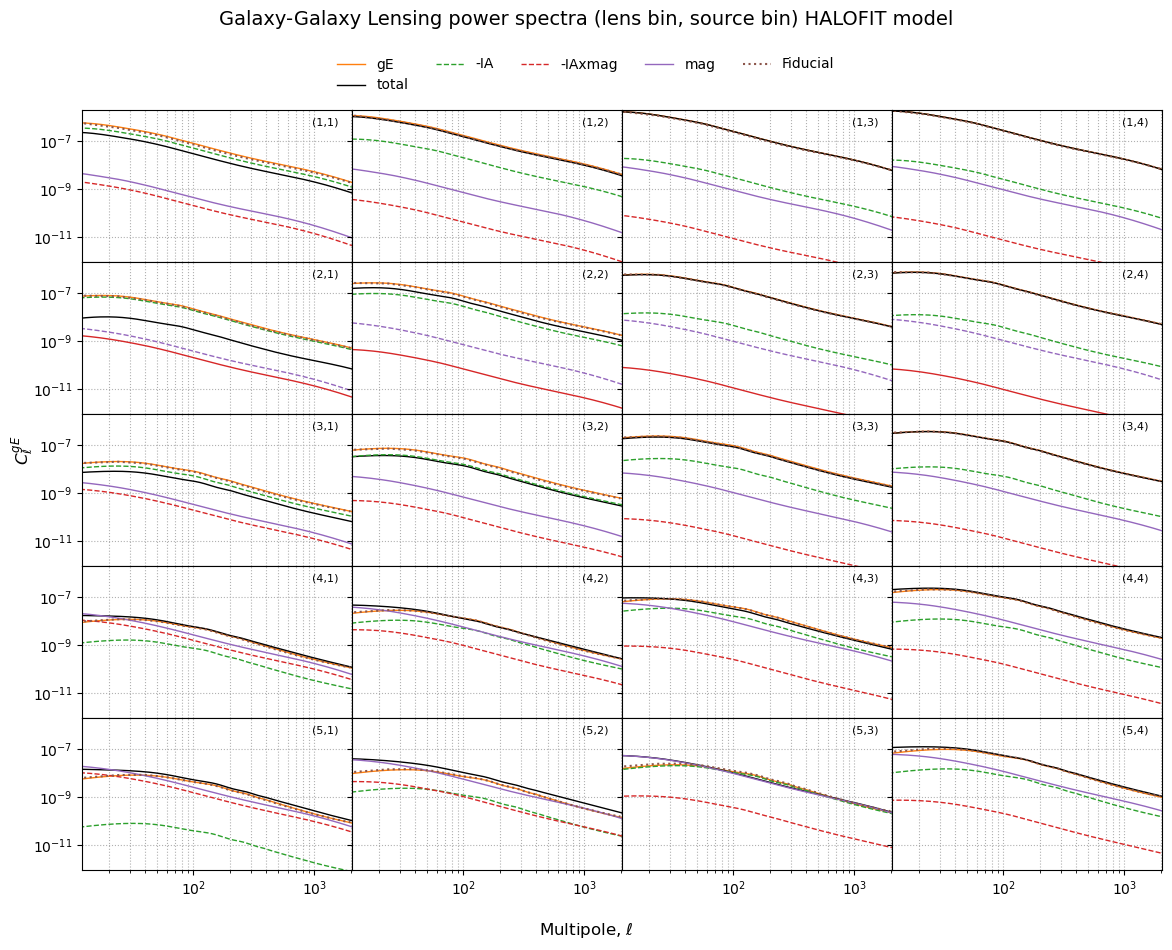

In [47]:
n_lens, n_source = 5, 4

from matplotlib.ticker import LogLocator

fig, axes = plt.subplots(
    n_lens, n_source,
    figsize=(12, 10),
    sharex=True,
    sharey=True
)

for i in range(n_lens):
    for j in range(n_source):

        ax = axes[i, j]

        # Main spectra
        ax.plot(ells, cls_ge[i, j, :], color='C1', lw=1, label='gE')
        ax.plot(ells, cls_ge[i, j, :]+cls_ia[i, j, :]+cls_ia_mag[i, j, :]+cls_mag[i, j, :], color='black', lw=1, label='total')

        if np.all(cls_ia[i, j, :] < 0):
            ax.plot(ells, -cls_ia[i, j, :], linestyle='--',color='C2', lw=1, label='-IA')
        else:
            ax.plot(ells, cls_ia[i, j, :], linestyle='-',color='C2', lw=1, label='IA')

        if np.all(cls_ia_mag[i, j, :] < 0):
            ax.plot(ells, -cls_ia_mag[i, j, :], linestyle='--',color='C3', lw=1, label='-IAxmag')
        else:
            ax.plot(ells, cls_ia_mag[i, j, :], linestyle='-',color='C3', lw=1, label='IAxmag')

        if np.all(cls_mag[i, j, :] < 0):
            ax.plot(ells, -cls_mag[i, j, :], linestyle='--',color='C4', lw=1, label='-mag')
        else:
            ax.plot(ells, cls_mag[i, j, :], linestyle='-',color='C4', lw=1, label='mag')

        cl_fid = np.array([cls_fid['VALUE'][x] for x in range(len(cls_fid)) if cls_fid['BIN1'][x]==i+1 and cls_fid['BIN2'][x]==j+1])
        l_bins_fid = np.array([cls_fid['ANG'][x] for x in range(len(cls_fid)) if cls_fid['BIN1'][x]==i+1 and cls_fid['BIN2'][x]==j+1])
        ax.plot(l_bins_fid, cl_fid,color='C5', linestyle=':', label='Fiducial')



        # Bin label
        ax.text(
            0.95, 0.95, f"({i+1},{j+1})",
            transform=ax.transAxes,
            ha="right", va="top", fontsize=8
        )

        ax.set_xscale("log")
        ax.set_yscale("log")

        ax.set_xlim(12,ells.max())
        ax.set_ylim(9e-13,2e-6)

        # Grid (shared visually because axes are shared)
        ax.grid(True, which="both", ls=":")

        ax.yaxis.set_major_locator(LogLocator(numticks=4))
        ax.xaxis.set_major_locator(LogLocator(numticks=3))


# Shared axis labels
fig.supxlabel(r"Multipole, $\ell$", fontsize=12)
fig.supylabel(r"$C_{\ell}^{gE}$", fontsize=12)

fig.suptitle(
    'Galaxy-Galaxy Lensing power spectra (lens bin, source bin) '+name+' model',
    fontsize=14,
    y=0.94
)

handles, labels = axes[0, 0].get_legend_handles_labels()

fig.legend(
    handles, labels,
    loc='upper center',
    ncol=5,
    frameon=False,
    bbox_to_anchor=(0.5, 0.905)  # <-- just beneath the suptitle
)


plt.subplots_adjust(
    wspace=0.0, hspace=0.0,
    top=0.84,   # lowered to make room for legend
    bottom=0.08,
    left=0.08,
    right=0.98
)

plt.show()